In [3]:


import cv2
import os
import matplotlib.pyplot as plt
import numpy as np


def add_text_to_image (img:np.ndarray, round:str, step:str, reward_per_capita:str)->np.ndarray:
    """
    Adds text to the image.

    Args:
    - img: the image to which the text will be added.
    - round: the round number.
    - reward_per_capita: the reward per capita for the current round.

    Returns:
    - img: the image with the text added.
    """

    height, _, _ = img.shape
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"Round: {round} - Step {step}- Reward per capita: {reward_per_capita}"
    cv2.putText(img, text, (12, int(height * 0.035)), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return img

def read_rewards_from_file(file_path:str)-> dict:
    """
    Read the rewards history file and returns a dictionary with the total reward and the individual reward for each step.
    Args:
        file_path: the path to the rewards history file.

    Returns:
        total_rewards: a dictionary that maps the step number with the total reward for that step.
        individual_rewards: a dictionary that maps the step number with the individual reward for each agent for that step.
    """

    with open(file_path, "r") as f:
        lines = f.readlines()
        
    rewards_per_step = {}
    for line in lines:
        step, rewards_str = line.strip().split(':')[0], line[line.find(':')+1:]
        rewards_dict = eval(rewards_str.strip())
        rewards_per_step[step] = rewards_dict
    
    individual_rewards = {'1': rewards_per_step['1']}
    for step in range(2, len(rewards_per_step)):
        # Suma del anterior con el actual
        individual_rewards[str(step)] = {key: individual_rewards[str(step-1)][key] + rewards_per_step[str(step)][key] for key in rewards_per_step[str(step)].keys()}


    total_rewards = {'1': sum(rewards_per_step['1'].values())}
    for step in range(2, len(rewards_per_step)):
        # Suma del anterior con el actual
        total_rewards[str(step)] = sum(individual_rewards[str(step)].values())
    
    return total_rewards, individual_rewards

def read_rounds_history(file_path:str, image_folder:str):
    """
    Reads the rounds history file and returns a dictionary that maps the step number with the round number.
    
    Args:
        file_path: the path to the rounds history file.

    Returns:
        round_map: a dictionary that maps the step number with the round number.
    """
    with open(file_path, "r") as f:
        lines = f.readlines()
     
    # Obteniendo las imágenes de la carpeta
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
    images.sort(key=lambda x: int(x.split('.')[0]))  # Asumiendo que el nombre del archivo es el "step" y no tiene puntos adicionales
    max_image_step = int(images[-1][:-4])
    
    round_map = {}
    for line in lines:
        round, step = line.strip().split(' ')
        round_map[step] = round
    max_step = max([int(step) for step in round_map.keys()])

    if max_image_step != max_step:
        round_map[str(max_image_step)] = str(int(round_map[str(max_step)]) + 1)
        max_step = max_image_step

    round_map['0'] = '1'
    for step in range(1, max_step+1):
        if str(step) not in round_map.keys():
            round_map[str(step)] = round_map[str(step-1)]
    return round_map

def generate_video_from_images(image_folder:str, video_name:str, rewards:dict, round_map:dict, output_resolution:tuple, duration:float=0.2)->None:

    """
    Generate a video from a set of images.

    Parameters:
    - image_folder: the path to the folder containing the images.
    - video_name: the name (including path) of the video file to be created.
    - rewards: a dictionary that maps the step number with the total reward for that step.
    - output_resolution: the resolution of the output video.
    - duration: the duration each image will be displayed in seconds.
    """

    # Obteniendo las imágenes de la carpeta
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
    images.sort(key=lambda x: int(x.split('.')[0]))  # Asumiendo que el nombre del archivo es el "step" y no tiene puntos adicionales
    max_image_step = int(images[-1][:-4])
    
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 1/duration, output_resolution)

    for i in range(len(images)):
        img_path = os.path.join(image_folder, images[i])
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, output_resolution, interpolation=cv2.INTER_NEAREST)  # Redimensiona la imagen a la resolución deseada

        # Añadiendo el texto a la imagen
        step = images[i].split('.')[0]
        reward = rewards.get(step, "N/A")
        img_with_text = add_text_to_image(img_resized, round_map[str(int(step))], step, reward)

        out.write(img_with_text)

    out.release()

    return max_image_step


def generate_rewards_plot (individual_rewards:dict, round_map:dict, record_folder:str)->None:
    """
    Generates a plot with the individual rewards and the cumulative average reward per step.

    Args:
        individual_rewards: a dictionary that maps the step number with the individual reward for each agent for that step.
        round_map: a dictionary that maps the step number with the round number.
        record_folder: the path to the record folder.
    """
    # Uses round map to evaluate only the steps that are part of a round from individual rewards
    individual_rewards = { round_map[step]: rew for step, rew in individual_rewards.items()}

    steps = list(individual_rewards.keys())
    steps = [int(s) for s in steps]
    cumulative_averages = [sum(list(val.values()))/3 for val in individual_rewards.values()]
    individual_rewards = [list(val.values()) for val in individual_rewards.values()]

    # Transform to numpy array
    individual_rewards = np.array(individual_rewards)

    # Graph
    plt.figure(figsize=(12, 6))
    # Vector of colors for each individual
    colors = ['blue', 'purple', 'magenta']
    for i in range(individual_rewards.shape[1]):
        plt.plot(steps, individual_rewards[:, i], label=f"Individual {i+1}", linewidth=2, linestyle="--", color=colors[i])
    plt.plot(steps, cumulative_averages, label="Cumulative Average", linewidth=2.5, linestyle="-", color="orange")
    plt.xticks(rotation=90, ha='right')

    plt.xlabel("ROunds")
    plt.ylabel("Reward")
    plt.title("Individual reward vs Cumulative average reward per Round")
    plt.legend()
    plt.grid(True)
    plt.savefig(record_folder + '/rewards_plot.png')



def recreate_records(record_path:str, image_folder:str = 'world', video_name:str = 'output_video.avi', output_resolution:tuple = (1600, 1200), rounds_file:str = 'steps_history.txt', rewards_file:str = 'rewards_history.txt')->None:
    """
    Recreates the simulation from the given record folder.

    Args:
    - record_folder: the path to the record folder.
    - image_folder: the path to the folder containing the images.
    - video_name: the name (including path) of the video file to be created.
    - output_resolution: the resolution of the output video.
    """
    rounds_path = os.path.join(record_path, rounds_file)
    rewards_path = os.path.join(record_path, rewards_file)
    image_path = os.path.join(record_path, image_folder)
    video_path = os.path.join(record_path, video_name)

    total_rewards, individual_rewards = read_rewards_from_file(rewards_path)
    round_map = read_rounds_history(rounds_path, image_path)
    generate_video_from_images(image_path, video_path, total_rewards, round_map, output_resolution, 0.2)
    generate_rewards_plot( individual_rewards, round_map, record_path)

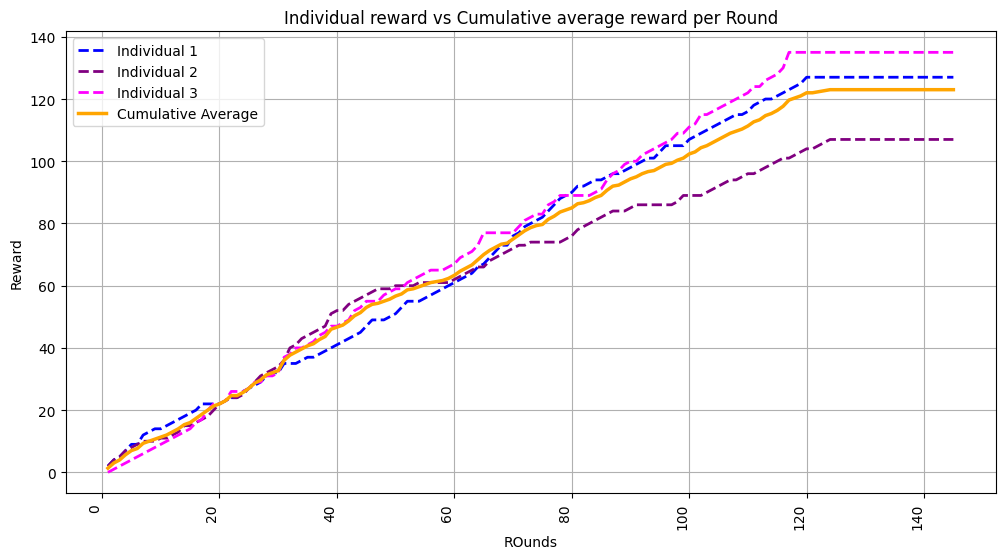

In [4]:
LOG_PATH = "/home/jeyseb/MeltingPot/CooperativeGPT/logs/2023-10-22--01-34-40"
recreate_records(LOG_PATH) 